In [1]:
#import libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans





# Set display options
pd.set_option('display.max_columns', None)  # None means unlimited
pd.set_option('display.max_rows', None)  # None means unlimited
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def wrangle(filepath):
    # Read csv file into dataframe
    df = pd.read_csv(filepath)
    
    # Remove duplicated values
    df.drop_duplicates(subset="id", inplace=True)
    
    # Convert date to datetime and split
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    
    # Drop date and id column
    df.drop(["date", "id"], axis=1, inplace=True)

    # Drop multicolinear variables
    df.drop(["sqft_above", "sqft_above"], axis=1, inplace=True)
    
    # Add other data wrangling steps here if needed
    
    return df


In [3]:
df = wrangle(r"C:\Users\eakli\Downloads\task\ecole\house-pricing-prediction\apartment-hunter\data\raw\kc_house_data.csv")

In [4]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [5]:
df.shape

(21436, 21)

In [6]:
df["price"].describe().apply("{0:,.0f}".format)

count       21,436
mean       540,529
std        367,689
min         75,000
25%        322,150
50%        450,000
75%        645,000
max      7,700,000
Name: price, dtype: object

<Axes: xlabel='price', ylabel='Count'>

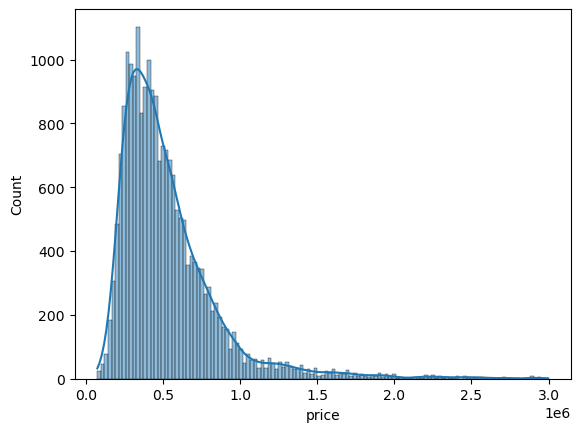

In [32]:
price_less_3e6 = df[df["price"] < 3_000_000]
price_less_3e6["sqft_living"].describe().apply("{0:,.0f}".format)
price_less_3e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_less_3e6["price"], kde=True)

(21238, 21)


count       21,238
mean       519,694
std        287,813
min         75,000
25%        320,000
50%        450,000
75%        635,438
max      2,000,000
Name: price, dtype: object

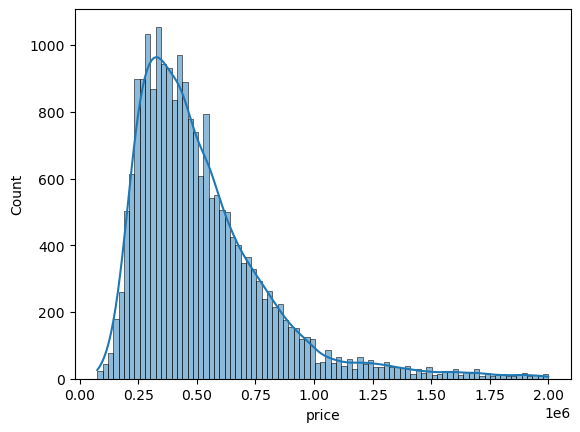

In [50]:
price_equals_less_2e6 = df[df["price"] <= 2_000_000]
price_equals_less_2e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_2e6["price"], kde=True)

print(price_equals_less_2e6.shape)
price_equals_less_2e6["price"].describe().apply("{0:,.0f}".format)



(19979, 21)


count       19,979
mean       467,931
std        196,437
min         75,000
25%        314,950
50%        435,000
75%        594,000
max      1,000,000
Name: price, dtype: object

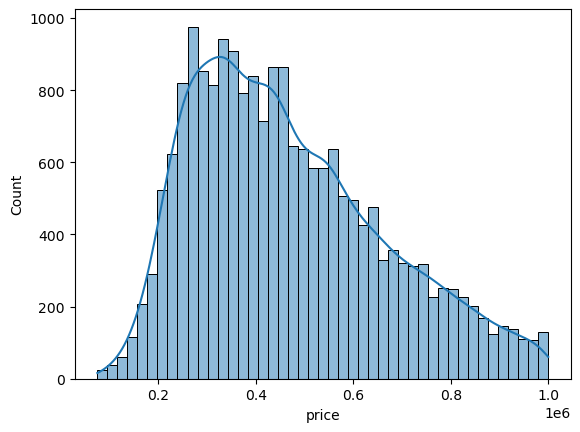

In [46]:
price_equals_less_1e6 = df[df["price"] <= 1_000_000]
price_equals_less_1e6["sqft_living"].describe().apply("{0:,.0f}".format)
# price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_1e6["price"], kde=True)
print(price_equals_less_1e6.shape)

price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


(50, 21)


count           50
mean     3,819,715
std      1,088,118
min      3,000,000
25%      3,176,562
50%      3,397,500
75%      3,837,500
max      7,700,000
Name: price, dtype: object

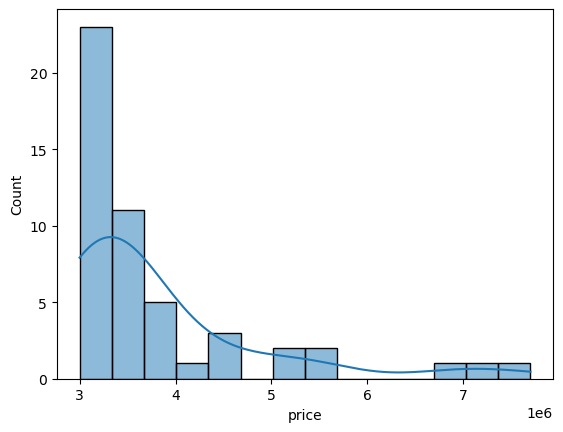

In [48]:
price_over_3e6 = df[df["price"] >= 3_000_000]
price_over_3e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_over_3e6["price"], kde=True)
print(price_over_3e6.shape)
price_over_3e6["price"].describe().apply("{0:,.0f}".format)


In [39]:
#Handling outliers for "price" - here we are just checking extreme values
price_Q1 = df["price"].quantile(0.25)
price_Q3 = df["price"].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)

outliers_df = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

outliers_df["price"].describe().apply("{0:,.0f}".format)

count        1,139
mean     1,667,952
std        653,911
min      1,130,000
25%      1,260,250
50%      1,450,000
75%      1,815,000
max      7,700,000
Name: price, dtype: object

In [ ]:
# Handling outliers for 'price' - here we are just checking for extreme values
price_Q1 = df['price'].quantile(0.25)
price_Q3 = df['price'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)
outliers_df = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

# Dropping the extreme outliers for 'price'
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Checking the new shape of the dataset after cleaning
new_shape = df.shape

In [ ]:
# # Convert 'zipcode' to a string format
# df['zipcode'] = df['zipcode'].astype(str)

In [ ]:
zipcode_avg_price = df.groupby('zipcode')['price'].mean()#.sort_values(ascending=False)


In [ ]:
# Prepare the data for feature enginnering
geo_data = df[['zipcode', 'lat', 'long']].drop_duplicates()
geo_data['avg_price'] = geo_data['zipcode'].map(zipcode_avg_price)

# Scale the features
scaler = StandardScaler()
geo_data_scaled = scaler.fit_transform(geo_data[['lat', 'long', 'avg_price']])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
geo_data['cluster'] = kmeans.fit_predict(geo_data_scaled)

# Create a mapping from zipcode to cluster
zipcode_to_cluster = geo_data.set_index('zipcode')['cluster'].to_dict()

# Map the geographic groupings back to the original properties
df['geo_group'] = df['zipcode'].map(zipcode_to_cluster)


In [ ]:
df.head()

In [ ]:
# Assuming df is your DataFrame and 'bathrooms' is the column of interest
df['full_bathrooms'] = df['bathrooms'].apply(lambda x: int(x))  # Full bathrooms are the integer part
df['half_bathrooms'] = df['bathrooms'].apply(lambda x: (x - int(x)) * 2)  # Half bathrooms are the fractional part, multiplied by 2

# Create a feature for unusual bathroom counts
df['unusual_bath_count'] = df['bathrooms'].isin([0, 0.75]).astype(int)

# Investigate properties with 0 bathrooms
properties_with_no_bathrooms = df[df['bathrooms'] == 0]

In [ ]:
corr_matrix = df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Including Date Features')
plt.show()